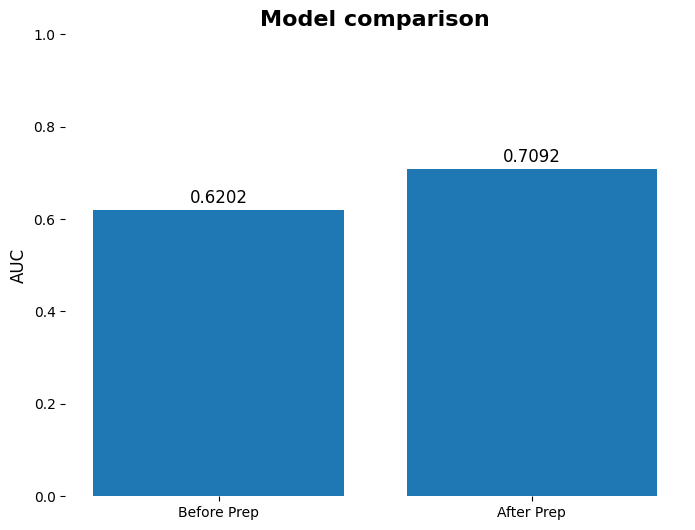

In [1]:
import matplotlib.pyplot as plt

# Data
models = ['Before Prep', 'After Prep']
auc_values = [0.6202, 0.7092]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, auc_values)

# Remove spines
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Remove grid
plt.grid(False)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
             f"{yval:.4f}", ha='center', va='bottom', fontsize=12)

# Title & labels
plt.title("Model comparison", fontsize=16, fontweight='bold')
plt.ylabel("AUC", fontsize=12)

plt.ylim(0, 1)   # Keep AUC in valid range

plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ==== Hàm tính VIF ====
def compute_vif(df):
    vif_df = pd.DataFrame()
    vif_df["feature"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

# ==== Phân loại biến ====
def get_feature_types(df):
    continuous = [col for col in df.columns if df[col].nunique() > 20]
    binary = [col for col in df.columns if df[col].nunique() == 2]
    onehot = [col for col in df.columns if 3 <= df[col].nunique() <= 20]
    rare = [col for col in df.columns if df[col].value_counts(normalize=True).min() < 0.01]
    return continuous, binary, onehot, rare
# For logistic regression feature selection
#Step 1: Variance Threshold by feature type
def variance_threshold_by_type(df):
    continuous, binary, onehot, rare = get_feature_types(df)

    print("Continuous:", continuous)
    print("Binary:", binary)
    print("One-hot:", onehot)
    print("Rare:", rare)

    # Binary: threshold 1%-5%
    selector_binary = VarianceThreshold(threshold=0.01)
    df_binary = pd.DataFrame(selector_binary.fit_transform(df[binary]),
                             columns=np.array(binary)[selector_binary.get_support()])

    # One-hot encoded: threshold 0.0005–0.005
    selector_onehot = VarianceThreshold(threshold=0.0005)
    df_onehot = pd.DataFrame(selector_onehot.fit_transform(df[onehot]),
                             columns=np.array(onehot)[selector_onehot.get_support()])

    # Continuous giữ nguyên
    df_cont = df[continuous]

    # Rare category → thay bằng “Rare”
    df_rare = df.copy()
    for col in rare:
        freq = df[col].value_counts(normalize=True)
        rare_labels = freq[freq < 0.01].index
        df_rare[col] = df_rare[col].replace(rare_labels, "Rare")

    return pd.concat([df_cont, df_binary, df_onehot], axis=1)
#Step 2: Calculate correlations
def compute_correlations(df, target):
    corr = df.corrwith(target)
    corr = corr.abs().sort_values(ascending=False)
    return corr
# Step 3: Remove high VIF features
def remove_high_vif(df, threshold=10):
    df_copy = df.copy()
    while True:
        vif = compute_vif(df_copy)
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            col_to_remove = vif.loc[vif["VIF"].idxmax(), "feature"]
            print(f"Removing {col_to_remove} with VIF={max_vif:.2f}")
            df_copy = df_copy.drop(columns=[col_to_remove])
        else:
            break
    return df_copy
#Step 4: Select K best features
def statistical_selection(df, target, k=20):
    selector_chi2 = SelectKBest(score_func=chi2, k=k)
    selector_chi2.fit(df, target)

    selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
    selector_mi.fit(df, target)

    features_chi2 = df.columns[selector_chi2.get_support()]
    features_mi = df.columns[selector_mi.get_support()]

    selected = set(features_chi2).union(set(features_mi))
    return list(selected)
# Step 5: L1 Regularization
def l1_feature_selection(df, target, C=0.1):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    model = LogisticRegression(penalty="l1", solver="liblinear", C=C)
    model.fit(X_scaled, target)

    coef = pd.Series(model.coef_[0], index=df.columns)
    selected = coef[coef != 0].indeX_train.tolist()

    return selected, coef
# Feature Selection for tree-based models
#Step 1: Variance Threshold by feature type
def tree_model_variance(df):
    return variance_threshold_by_type(df)
#Step 2: Feature Selection 
def tree_model_feature_selection(df, target, k=30):
    df1 = tree_model_variance(df)
    selected_stat = statistical_selection(df1, target, k=k)
    final_df = df1[selected_stat]
    return final_df


In [11]:
def logistic_regression_feature_selection(df, target):
    print("\n=== B1: Variance Threshold ===")
    df1 = variance_threshold_by_type(df)

    print("\n=== B2: Correlation with TARGET ===")
    corr = compute_correlations(df1, target)
    print(corr.head(20))

    print("\n=== B3: Remove high VIF ===")
    df2 = remove_high_vif(df1)

    print("\n=== B4: Chi2 + Mutual Information ===")
    selected_stat = statistical_selection(df2, target, k=20)
    df3 = df2[selected_stat]

    print("\n=== B5: L1 Logistic Regression ===")
    selected_l1, coef_l1 = l1_feature_selection(df3, target)

    final_features = selected_l1
    print("\n🎉 FEATURES CUỐI CÙNG:", final_features)

    return final_features


In [12]:
import importlib
import pipeline
importlib.reload(pipeline)
import sys
sys.path.append("..")
from processing.function import *
from pipeline import *
def load_preprocessing_pipeline(filepath: str):
    """
    Load preprocessing pipeline from disk
    
    Parameters:
    -----------
    filepath : str
        Path to load pipeline from
        
    Returns:
    --------
    pipeline : sklearn.pipeline.Pipeline
        Loaded preprocessing pipeline
    """
    pipeline = joblib.load(filepath)
    print(f"Preprocessing pipeline loaded from {filepath}")
    return pipeline
pipeline_path = '../models/preprocessing_pipeline.pkl'

try:
    preprocessing_pipeline = load_preprocessing_pipeline(pipeline_path)
except FileNotFoundError:
    raise FileNotFoundError(
        f"Preprocessing pipeline not found at '{pipeline_path}'. "
                f"Please ensure the pipeline is saved at this location."
        )

Preprocessing pipeline loaded from ../models/preprocessing_pipeline.pkl


In [13]:

df = pd.read_csv('../raw_data/train.csv')
df = df.copy()
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['TARGET'])

In [14]:
train_df.shape

(172206, 75)

In [15]:
train_processed = preprocessing_pipeline.fit_transform(train_df)
val_processed = preprocessing_pipeline.transform(val_df)

Label encoding: CODE_GENDER (2 categories)
Label encoding: FLAG_OWN_CAR (2 categories)
Label encoding: FLAG_OWN_REALTY (2 categories)
One-hot encoding: NAME_CONTRACT_TYPE (2 categories)
One-hot encoding: NAME_INCOME_TYPE (8 categories)
One-hot encoding: NAME_FAMILY_STATUS (6 categories)
One-hot encoding: NAME_HOUSING_TYPE (6 categories)
One-hot encoding: NAME_TYPE_SUITE (8 categories)
One-hot encoding: WEEKDAY_APPR_PROCESS_START (7 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_HOUR_CAT (2 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_DAY_CAT (2 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_WEEK_CAT (3 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_MON_CAT (3 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_QRT_CAT (3 categories)
One-hot encoding: AMT_REQ_CREDIT_BUREAU_YEAR_CAT (4 categories)



🌲 Training Random Forest...
✅ Model training complete!

🔢 Prediction Counts (Test Set):
0    43047
1        5
Name: count, dtype: int64

📌 RANDOM FOREST PERFORMANCE
Metric               Train                Test                
------------------------------------------------------------
Accuracy             0.9289               0.9193              
ROC-AUC              0.9964               0.7359              
F1-Score             0.2135               0.0023              
Precision            1.0000               0.8000              
Recall               0.1195               0.0012              

📋 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     39576
           1       0.80      0.00      0.00      3476

    accuracy                           0.92     43052
   macro avg       0.86      0.50      0.48     43052
weighted avg       0.91      0.92      0.88     43052


🎯 Top 15 Most Important Featur

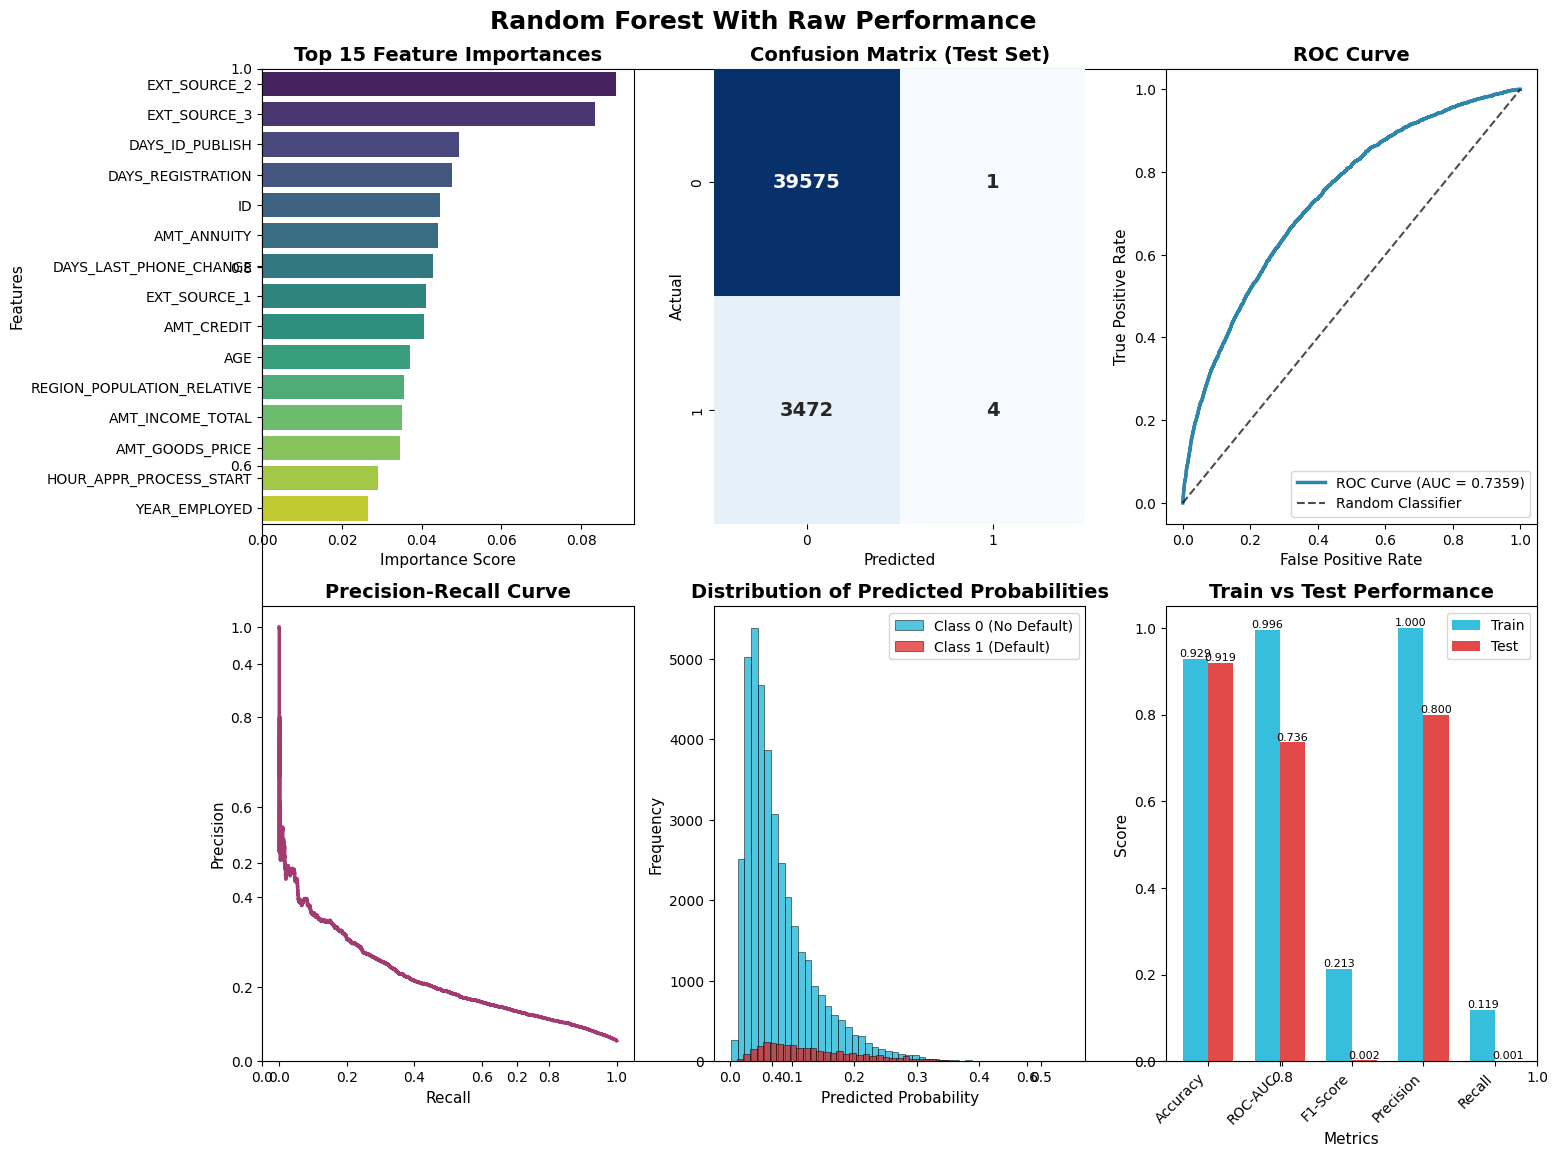


🎯 MODEL SUMMARY
   Model Type         : Random Forest Classifier
   Number of Trees    : 200
   Max Depth          : 20
   Min Samples Split  : 5
   Min Samples Leaf   : 2
   Max Features       : sqrt
   Training Samples   : 172,206
   Test Samples       : 43,052
   Number of Features : 88


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, 
                             confusion_matrix, roc_curve, precision_recall_curve, 
                             f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Data preparation
# df = df.copy()
# df = df.dropna()
# print(f'📊 Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns')

# # Features and target
# X = df.drop('TARGET', axis=1)
# y = df['TARGET']

# Select only numeric columns
# numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# X = X[numeric_cols]
# print(f'📊 Using {len(numeric_cols)} numeric features')

# Train-test split

X_train, X_test, y_train, y_test = train_processed.drop('TARGET', axis=1), val_processed.drop('TARGET', axis=1), \
                                                   train_processed['TARGET'], val_processed['TARGET']




# ========================================
# Train Random Forest Model
# ========================================
print("\n🌲 Training Random Forest...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
print("✅ Model training complete!")

# ========================================
# Predictions
# ========================================
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("\n🔢 Prediction Counts (Test Set):")
print(pd.Series(y_test_pred).value_counts())

# ========================================
# Evaluation Metrics
# ========================================
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\n" + "="*60)
print("📌 RANDOM FOREST PERFORMANCE")
print("="*60)
print(f"{'Metric':<20} {'Train':<20} {'Test':<20}")
print("-"*60)
print(f"{'Accuracy':<20} {train_acc:<20.4f} {test_acc:<20.4f}")
print(f"{'ROC-AUC':<20} {train_auc:<20.4f} {test_auc:<20.4f}")
print(f"{'F1-Score':<20} {train_f1:<20.4f} {test_f1:<20.4f}")
print(f"{'Precision':<20} {train_precision:<20.4f} {test_precision:<20.4f}")
print(f"{'Recall':<20} {train_recall:<20.4f} {test_recall:<20.4f}")
print("="*60)

print("\n📋 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


# Feature Importance
# ========================================
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# ========================================
# VISUALIZATIONS
# ========================================

# Set style
fig = plt.figure(figsize=(16, 12))
plt.grid(False)
fig.suptitle("Random Forest With Raw Performance",
             fontsize=18, fontweight='bold', y=0.98)
# 1. Feature Importance Plot
ax1 = plt.subplot(2, 3, 1)
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis', ax=ax1)
ax1.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_ylabel('Features', fontsize=11)

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax3.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2.5, color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax4.plot(recall, precision, linewidth=2.5, color='#A23B72')
ax4.set_xlabel('Recall', fontsize=11)
ax4.set_ylabel('Precision', fontsize=11)
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_test_proba[y_test == 0], bins=50, alpha=0.7, label='Class 0 (No Default)', 
         color='#06AED5', edgecolor='black', linewidth=0.5)
ax5.hist(y_test_proba[y_test == 1], bins=50, alpha=0.7, label='Class 1 (Default)', 
         color='#DD1C1A', edgecolor='black', linewidth=0.5)
ax5.set_xlabel('Predicted Probability', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)

# 6. Performance Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall'],
    'Train': [train_acc, train_auc, train_f1, train_precision, train_recall],
    'Test': [test_acc, test_auc, test_f1, test_precision, test_recall]
})
x = np.arange(len(metrics_df))
width = 0.35
bars1 = ax6.bar(x - width/2, metrics_df['Train'], width, label='Train', color='#06AED5', alpha=0.8)
bars2 = ax6.bar(x + width/2, metrics_df['Test'], width, label='Test', color='#DD1C1A', alpha=0.8)
ax6.set_xlabel('Metrics', fontsize=11)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_title('Train vs Test Performance', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

plt.show()

# ========================================
# Model Summary
# ========================================
print("\n" + "="*60)
print("🎯 MODEL SUMMARY")
print("="*60)
print(f"   Model Type         : Random Forest Classifier")
print(f"   Number of Trees    : {model.n_estimators}")
print(f"   Max Depth          : {model.max_depth}")
print(f"   Min Samples Split  : {model.min_samples_split}")
print(f"   Min Samples Leaf   : {model.min_samples_leaf}")
print(f"   Max Features       : {model.max_features}")
print(f"   Training Samples   : {X_train.shape[0]:,}")
print(f"   Test Samples       : {X_test.shape[0]:,}")
print(f"   Number of Features : {X_train.shape[1]}")
print("="*60)

In [ ]:
X_train.select_dtypes(include = ['category', 'object']).columns

Index(['ORGANISATION_TYPE'], dtype='object')

In [ ]:
X_train.select_dtypes(include = ['category', 'object'])

,NAME_TYPE_SUITE,WEEKDAY_APPR_PROCESS_START,ORGANISATION_TYPE,AMT_REQ_CREDIT_BUREAU_HOUR_CAT,AMT_REQ_CREDIT_BUREAU_DAY_CAT,AMT_REQ_CREDIT_BUREAU_WEEK_CAT,AMT_REQ_CREDIT_BUREAU_MON_CAT,AMT_REQ_CREDIT_BUREAU_QRT_CAT,AMT_REQ_CREDIT_BUREAU_YEAR_CAT
155266,Unaccompanied,TUESDAY,Business Entity Type 3,ZERO,ZERO,ZERO,ZERO,ZERO,ZERO
209617,Unaccompanied,FRIDAY,Self-employed,ZERO,ZERO,ZERO,ZERO,ZERO,MEDIUM
117647,Unaccompanied,SATURDAY,Trade: type 7,ZERO,ZERO,ZERO,ZERO,ZERO,LOW
68137,Unaccompanied,WEDNESDAY,Business Entity Type 3,ZERO,ZERO,ZERO,LOW,LOW,LOW
109938,"Spouse, partner",MONDAY,Business Entity Type 3,ZERO,ZERO,ZERO,ZERO,ZERO,MEDIUM
...,...,...,...,...,...,...,...,...,...
146703,Unaccompanied,WEDNESDAY,Self-employed,ZERO,ZERO,ZERO,ZERO,ZERO,ZERO
15563,Unaccompanied,SATURDAY,Industry: type 9,ZERO,ZERO,ZERO,ZERO,ZERO,ZERO
158128,Unaccompanied,THURSDAY,Business Entity Type 3,HAS_ENQUIRY,ZERO,ZERO,ZERO,LOW,LOW
73194,Unaccompanied,FRIDAY,Trade: type 7,ZERO,ZERO,ZERO,ZERO,ZERO,HIGH



📈 Training Logistic Regression...
✅ Model training complete!

🔢 Prediction Counts (Test Set):
0    22495
1    20557
Name: count, dtype: int64

📌 LOGISTIC REGRESSION PERFORMANCE
Metric               Train                Test                
------------------------------------------------------------
Accuracy             0.5324               0.5330              
ROC-AUC              0.5835               0.5728              
F1-Score             0.1687               0.1634              
Precision            0.0985               0.0955              
Recall               0.5878               0.5647              

🔹 TRAIN PERFORMANCE - Per Class
  Class 0 - Precision: 0.9358, Recall: 0.5275, F1: 0.6747
  Class 1 - Precision: 0.0985, Recall: 0.5878, F1: 0.1687

🔹 TEST PERFORMANCE - Per Class
  Class 0 - Precision: 0.9327, Recall: 0.5302, F1: 0.6761
  Class 1 - Precision: 0.0955, Recall: 0.5647, F1: 0.1634

📋 Classification Report (Test Set):
              precision    recall  f1-score   sup

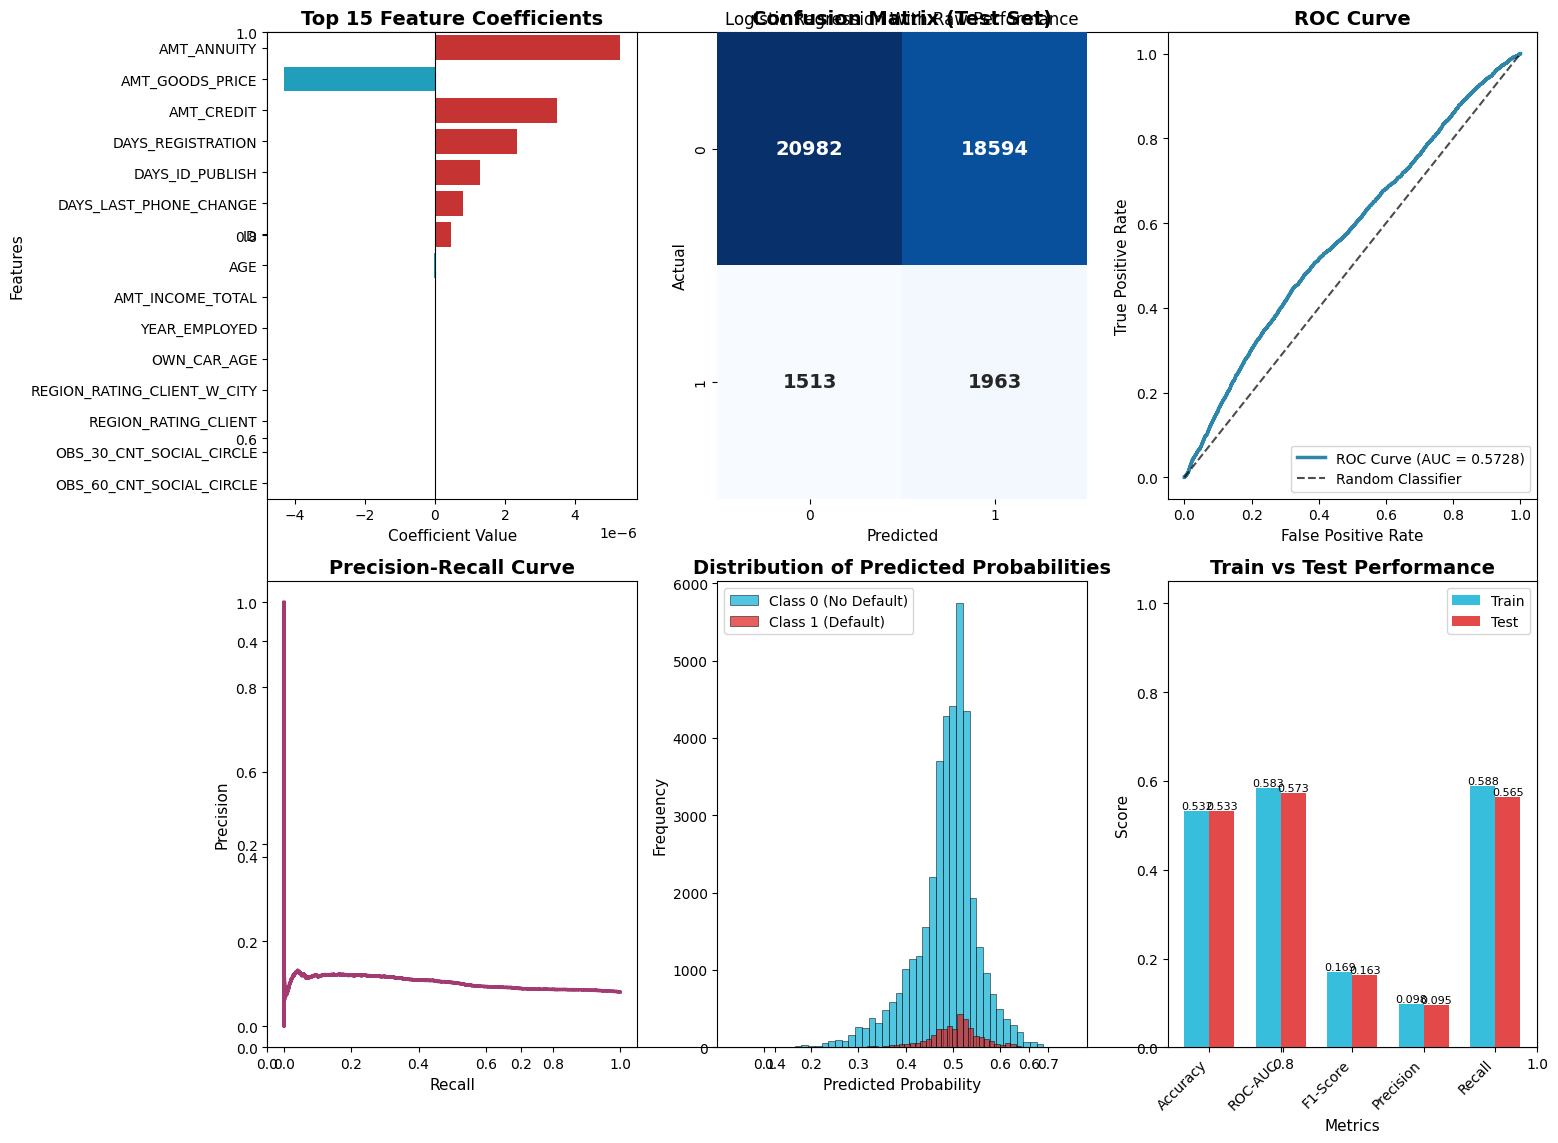


🎯 MODEL SUMMARY
   Model Type         : Logistic Regression
   Solver             : saga
   Max Iterations     : 1000
   Class Weight       : balanced
   Training Samples   : 172,206
   Test Samples       : 43,052
   Number of Features : 88


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, 
                             confusion_matrix, precision_score, recall_score, f1_score,
                             roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Prepare data


# Train-test split
X_train, X_test, y_train, y_test = train_processed.drop('TARGET', axis=1), val_processed.drop('TARGET', axis=1), \
                                                   train_processed['TARGET'], val_processed['TARGET']


# ---------------------------
# 2. Logistic Regression Pipeline
# ---------------------------
print("\n📈 Training Logistic Regression...")
clf = Pipeline(steps=[
    ('clf', LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, class_weight='balanced'))
])

# Train the model
clf.fit(X_train, y_train)
print("✅ Model training complete!")

# ---------------------------
# 3. Predictions
# ---------------------------
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)[:, 1]

y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("\n🔢 Prediction Counts (Test Set):")
print(pd.Series(y_test_pred).value_counts())

# ---------------------------
# 4. Evaluation Metrics
# ---------------------------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\n" + "="*60)
print("📌 LOGISTIC REGRESSION PERFORMANCE")
print("="*60)
print(f"{'Metric':<20} {'Train':<20} {'Test':<20}")
print("-"*60)
print(f"{'Accuracy':<20} {train_acc:<20.4f} {test_acc:<20.4f}")
print(f"{'ROC-AUC':<20} {train_auc:<20.4f} {test_auc:<20.4f}")
print(f"{'F1-Score':<20} {train_f1:<20.4f} {test_f1:<20.4f}")
print(f"{'Precision':<20} {train_precision:<20.4f} {test_precision:<20.4f}")
print(f"{'Recall':<20} {train_recall:<20.4f} {test_recall:<20.4f}")
print("="*60)

# Detailed per-class metrics
print("\n🔹 TRAIN PERFORMANCE - Per Class")
print(f"  Class 0 - Precision: {precision_score(y_train, y_train_pred, pos_label=0):.4f}, "
      f"Recall: {recall_score(y_train, y_train_pred, pos_label=0):.4f}, "
      f"F1: {f1_score(y_train, y_train_pred, pos_label=0):.4f}")
print(f"  Class 1 - Precision: {precision_score(y_train, y_train_pred, pos_label=1):.4f}, "
      f"Recall: {recall_score(y_train, y_train_pred, pos_label=1):.4f}, "
      f"F1: {f1_score(y_train, y_train_pred, pos_label=1):.4f}")

print("\n🔹 TEST PERFORMANCE - Per Class")
print(f"  Class 0 - Precision: {precision_score(y_test, y_test_pred, pos_label=0):.4f}, "
      f"Recall: {recall_score(y_test, y_test_pred, pos_label=0):.4f}, "
      f"F1: {f1_score(y_test, y_test_pred, pos_label=0):.4f}")
print(f"  Class 1 - Precision: {precision_score(y_test, y_test_pred, pos_label=1):.4f}, "
      f"Recall: {recall_score(y_test, y_test_pred, pos_label=1):.4f}, "
      f"F1: {f1_score(y_test, y_test_pred, pos_label=1):.4f}")

print("\n📋 Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# ---------------------------
# 5. Feature Coefficients (Feature Importance for Logistic Regression)
# ---------------------------
coefficients = clf.named_steps['clf'].coef_[0]
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n🎯 Top 15 Most Important Features (by absolute coefficient):")
print(feature_importance.head(15)[['feature', 'coefficient']].to_string(index=False))

# ========================================
# VISUALIZATIONS
# ========================================

fig = plt.figure(figsize=(16, 12))
plt.suptitle("Logistic Regression With Raw Performance")
# 1. Feature Importance (Coefficients) Plot
ax1 = plt.subplot(2, 3, 1)
top_features = feature_importance.head(15)
colors = ['#DD1C1A' if x > 0 else '#06AED5' for x in top_features['coefficient']]
sns.barplot(data=top_features, y='feature', x='coefficient', palette=colors, ax=ax1)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.set_title('Top 15 Feature Coefficients', fontsize=14, fontweight='bold')
ax1.set_xlabel('Coefficient Value', fontsize=11)
ax1.set_ylabel('Features', fontsize=11)

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax3.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2.5, color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax4.plot(recall, precision, linewidth=2.5, color='#A23B72')
ax4.set_xlabel('Recall', fontsize=11)
ax4.set_ylabel('Precision', fontsize=11)
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_test_proba[y_test == 0], bins=50, alpha=0.7, label='Class 0 (No Default)', 
         color='#06AED5', edgecolor='black', linewidth=0.5)
ax5.hist(y_test_proba[y_test == 1], bins=50, alpha=0.7, label='Class 1 (Default)', 
         color='#DD1C1A', edgecolor='black', linewidth=0.5)
ax5.set_xlabel('Predicted Probability', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)

# 6. Performance Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall'],
    'Train': [train_acc, train_auc, train_f1, train_precision, train_recall],
    'Test': [test_acc, test_auc, test_f1, test_precision, test_recall]
})
x = np.arange(len(metrics_df))
width = 0.35
bars1 = ax6.bar(x - width/2, metrics_df['Train'], width, label='Train', color='#06AED5', alpha=0.8)
bars2 = ax6.bar(x + width/2, metrics_df['Test'], width, label='Test', color='#DD1C1A', alpha=0.8)
ax6.set_xlabel('Metrics', fontsize=11)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_title('Train vs Test Performance', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# ========================================
# Model Summary
# ========================================
print("\n" + "="*60)
print("🎯 MODEL SUMMARY")
print("="*60)
print(f"   Model Type         : Logistic Regression")
print(f"   Solver             : saga")
print(f"   Max Iterations     : 1000")
print(f"   Class Weight       : balanced")
print(f"   Training Samples   : {X_train.shape[0]:,}")
print(f"   Test Samples       : {X_test.shape[0]:,}")
print(f"   Number of Features : {X_train.shape[1]}")
print("="*60)

In [ ]:
# ========================================
# Feature Importance
# ========================================
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# ========================================
# VISUALIZATIONS
# ========================================

# Set style
fig = plt.figure(figsize=(16, 12))
plt.grid(False)
fig.suptitle("Random Forest With Raw Performance",
             fontsize=18, fontweight='bold', y=0.98)
# 1. Feature Importance Plot
ax1 = plt.subplot(2, 3, 1)
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis', ax=ax1)
ax1.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_ylabel('Features', fontsize=11)

# 2. Confusion Matrix
ax2 = plt.subplot(2, 3, 2)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
            annot_kws={'size': 14, 'weight': 'bold'})
ax2.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11)
ax2.set_xlabel('Predicted', fontsize=11)

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax3.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2.5, color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
ax4.plot(recall, precision, linewidth=2.5, color='#A23B72')
ax4.set_xlabel('Recall', fontsize=11)
ax4.set_ylabel('Precision', fontsize=11)
ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_test_proba[y_test == 0], bins=50, alpha=0.7, label='Class 0 (No Default)', 
         color='#06AED5', edgecolor='black', linewidth=0.5)
ax5.hist(y_test_proba[y_test == 1], bins=50, alpha=0.7, label='Class 1 (Default)', 
         color='#DD1C1A', edgecolor='black', linewidth=0.5)
ax5.set_xlabel('Predicted Probability', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)

# 6. Performance Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall'],
    'Train': [train_acc, train_auc, train_f1, train_precision, train_recall],
    'Test': [test_acc, test_auc, test_f1, test_precision, test_recall]
})
x = np.arange(len(metrics_df))
width = 0.35
bars1 = ax6.bar(x - width/2, metrics_df['Train'], width, label='Train', color='#06AED5', alpha=0.8)
bars2 = ax6.bar(x + width/2, metrics_df['Test'], width, label='Test', color='#DD1C1A', alpha=0.8)
ax6.set_xlabel('Metrics', fontsize=11)
ax6.set_ylabel('Score', fontsize=11)
ax6.set_title('Train vs Test Performance', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
ax6.legend(fontsize=10)
ax6.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

plt.show()

# ========================================
# Model Summary
# ========================================
print("\n" + "="*60)
print("🎯 MODEL SUMMARY")
print("="*60)
print(f"   Model Type         : Random Forest Classifier")
print(f"   Number of Trees    : {model.n_estimators}")
print(f"   Max Depth          : {model.max_depth}")
print(f"   Min Samples Split  : {model.min_samples_split}")
print(f"   Min Samples Leaf   : {model.min_samples_leaf}")
print(f"   Max Features       : {model.max_features}")
print(f"   Training Samples   : {X_train.shape[0]:,}")
print(f"   Test Samples       : {X_test.shape[0]:,}")
print(f"   Number of Features : {X_train.shape[1]}")
print("="*60)

NameError: name 'pd' is not defined